In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import csc_matrix, csr_matrix

from data.synthetic_data import simulate_rating_matrix

# Loading the data and preprocessing it

In [ ]:
movies = pd.read_csv('data/ml-1m/ml-1m/movies.dat', sep='::', header=None, engine='python', encoding='ISO-8859-1', names=['MovieID', 'Title', 'Genres'])
ratings = pd.read_csv('data/ml-1m/ml-1m/ratings.dat', sep='::', header=None, engine='python', encoding='ISO-8859-1', names=['UserID', 'MovieID', 'Rating', 'Timestamp'])
users = pd.read_csv('data/ml-1m/ml-1m/users.dat', sep='::', header=None, engine='python', encoding='ISO-8859-1', names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'])

# Rebase IDs to be contiguous integers 0...N-1 (useful for matrix indexing)
user2idx = {old: new for new, old in enumerate(users['UserID'].unique())}
movie2idx = {old: new for new, old in enumerate(movies['MovieID'].unique())}

users['UserID'] = users['UserID'].map(user2idx)
movies['MovieID'] = movies['MovieID'].map(movie2idx)
ratings['UserID'] = ratings['UserID'].map(user2idx)
ratings['MovieID'] = ratings['MovieID'].map(movie2idx)

print('Movies shape:', movies.shape)
print(movies.head())
print('\n')

movies['Genres'] = movies['Genres'].str.split('|').apply(lambda x: set(x))
genres_set = set().union(*movies['Genres'])

print('Ratings shape:', ratings.shape)
print(ratings.head())
print('\n')

print('Users shape:', users.shape)
print(users.head())
print('\n')

print('Genres:', genres_set)

Movies shape: (3883, 3)
   MovieID                               Title                        Genres
0        0                    Toy Story (1995)   Animation|Children's|Comedy
1        1                      Jumanji (1995)  Adventure|Children's|Fantasy
2        2             Grumpier Old Men (1995)                Comedy|Romance
3        3            Waiting to Exhale (1995)                  Comedy|Drama
4        4  Father of the Bride Part II (1995)                        Comedy


Ratings shape: (1000209, 4)
   UserID  MovieID  Rating  Timestamp
0       0     1176       5  978300760
1       0      655       3  978302109
2       0      902       3  978301968
3       0     3339       4  978300275
4       0     2286       5  978824291


Users shape: (6040, 5)
   UserID Gender  Age  Occupation Zip-code
0       0      F    1          10    48067
1       1      M   56          16    70072
2       2      M   25          15    55117
3       3      M   45           7    02460
4       4      M

In [ ]:
ratings = pd.read_csv("data/df_merged.csv")

We turn rating into binary variables

In [4]:
ratings['binary_rating'] = ratings['Rating'].apply(lambda x: 1 if x >= 4 else 0)
ratings["Timestamp"] = pd.to_datetime(ratings["Timestamp"], unit='s')
ratings.head()

,MovieID,Title,Genres,Year,UserID,Rating,Timestamp,binary_rating
0,1,Toy Story,"['Animation', ""Children's"", 'Comedy']",1995,1,5,2001-01-06 23:37:48,1
1,1,Toy Story,"['Animation', ""Children's"", 'Comedy']",1995,6,4,2000-12-31 04:30:08,1
2,1,Toy Story,"['Animation', ""Children's"", 'Comedy']",1995,8,4,2000-12-31 03:31:36,1
3,1,Toy Story,"['Animation', ""Children's"", 'Comedy']",1995,9,5,2000-12-31 01:25:52,1
4,1,Toy Story,"['Animation', ""Children's"", 'Comedy']",1995,10,5,2000-12-31 01:34:34,1


In [5]:
# Create a set of triplets (UserID, MovieID, binary_rating)
ratings_triplets = set(zip(ratings['UserID'], ratings['MovieID'], ratings['binary_rating']))

# Verify the result
print(f'Number of unique triplets: {len(ratings_triplets)}')
list(ratings_triplets)[:5]

Number of unique triplets: 1000209


[(1032, 1210, 1),
 (5008, 1097, 1),
 (1125, 2391, 1),
 (1357, 2651, 1),
 (3411, 1518, 0)]

# Creating the KNN bandit class

In [ ]:
class KNNBandit:
    def __init__(self, k, ratings, alpha_prior=1.0, beta_prior=100.0):
        self.k = k
        self.alpha_prior = alpha_prior
        self.beta_prior = beta_prior
        
        # --- 1. ID MAPPING ---
        self.user_ids = ratings['UserID'].unique()
        self.item_ids = ratings['MovieID'].unique()
        
        self.user_map = {uid: i for i, uid in enumerate(self.user_ids)}
        self.item_map = {iid: i for i, iid in enumerate(self.item_ids)}
        
        self.rev_user_map = {i: uid for uid, i in self.user_map.items()}
        self.rev_item_map = {i: iid for iid, i in self.item_map.items()}
        
        self.n_users = len(self.user_ids)
        self.n_items = len(self.item_ids)
        
        # --- 2. GROUND TRUTH MATRICES ---
        rows = [self.user_map[u] for u in ratings['UserID']]
        cols = [self.item_map[i] for i in ratings['MovieID']]
        
        # A. RATING MATRIX (1.0 - 5.0) - Pour la prédiction
        data_rating = ratings['Rating'].values.astype(np.float32)
        self.R_csr_rating = csr_matrix((data_rating, (rows, cols)), shape=(self.n_users, self.n_items))
        
        # B. BINARY MATRIX (0.0 ou 1.0) - Pour le Reward et la mise à jour
        data_binary = ratings['binary_rating'].values.astype(np.float32)
        # CSC est important ici pour récupérer rapidement "Qui a aimé le film X" (colonne)
        self.R_csc_binary = csc_matrix((data_binary, (rows, cols)), shape=(self.n_users, self.n_items))
        self.R_csr_binary = csr_matrix((data_binary, (rows, cols)), shape=(self.n_users, self.n_items))
        
        # --- 3. INITIALIZE BANDIT PARAMETERS ---
        # CORRECTION : n devient une MATRICE (N, N) tout comme alpha
        # n[u, v] = nombre de fois où l'utilisateur u a testé une reco venant de v
        self.alpha = np.full((self.n_users, self.n_users), alpha_prior, dtype=np.float32)
        self.n = np.full((self.n_users, self.n_users), alpha_prior + beta_prior, dtype=np.float32)
        
        # --- 4. HISTORY TRACKING ---
        self.seen_mask = [set() for _ in range(self.n_users)]

    def simulate(self, n_interactions, max_attempts=None):
        list_of_recommendations = []
        
        if max_attempts is None:
            max_attempts = n_interactions * 200
            
        total_attempts = 0
        
        while len(list_of_recommendations) < n_interactions and total_attempts < max_attempts:
            total_attempts += 1
            
            u_idx = np.random.randint(self.n_users)
            
            # ==========================================================
            # PHASE 1: PREDICTION (Thompson Sampling)
            # ==========================================================
            
            #we compute beta and draw from beta distribution
            beta_params = self.n[u_idx] - self.alpha[u_idx]
            
            p = np.random.beta(self.alpha[u_idx], beta_params)
            p[u_idx] = -1.0 
            
            top_k_indices = np.argpartition(p, -self.k)[-self.k:]
            
            neighbor_weights = p[top_k_indices]
            neighbor_ratings = self.R_csr_rating[top_k_indices] 
            
            # each user recommand movies they prefered
            scores = neighbor_weights @ neighbor_ratings
            
            # if movie is already graded by the target user we set the score of this movie to -inf
            if self.seen_mask[u_idx]:
                scores[list(self.seen_mask[u_idx])] = -np.inf
            
            # all movies have been seen by the target user
            if scores.max() == -np.inf:
                continue

            # if all scores are negative we recommand a random movie 
            # (when we initialise the algorithm we don't know the preferences of other users, that lead to score <= 0)
            if scores.max() <= 0:
                 rec_item_idx = np.random.randint(self.n_items)
            else:
                rec_item_idx = np.argmax(scores)
            
            # ==========================================================
            # PHASE 2: ORACLE
            # ==========================================================
            
            # we update movies seen by the user and check that we have a note in our dataset
            start_ptr = self.R_csr_rating.indptr[u_idx]
            end_ptr = self.R_csr_rating.indptr[u_idx + 1]
            user_history_indices = self.R_csr_rating.indices[start_ptr:end_ptr]
            
            self.seen_mask[u_idx].add(rec_item_idx)
            
            if rec_item_idx not in user_history_indices:
                continue 
                
            # ==========================================================
            # PHASE 3: UPDATE (CORRECTED)
            # ==========================================================
            
            # we update self.alpha and self.n
            reward = self.R_csr_binary[u_idx, rec_item_idx] # 0 ou 1
            real_rating_val = self.R_csr_rating[u_idx, rec_item_idx]
            
            real_user_id = self.rev_user_map[u_idx]
            real_item_id = self.rev_item_map[rec_item_idx]
            
            list_of_recommendations.append([real_user_id, real_item_id, real_rating_val, reward])

            item_col_start = self.R_csc_binary.indptr[rec_item_idx]
            item_col_end = self.R_csc_binary.indptr[rec_item_idx + 1]
            
            users_indices = self.R_csc_binary.indices[item_col_start:item_col_end]
            users_values = self.R_csc_binary.data[item_col_start:item_col_end]
            
            neighbors_who_liked = users_indices[users_values == 1]
            
            if len(neighbors_who_liked) > 0:
                self.n[u_idx, neighbors_who_liked] += 1
                
                if reward == 1:
                    self.alpha[u_idx, neighbors_who_liked] += 1
                
        return list_of_recommendations

In [7]:
# Initialize the bandit
knn_bandit = KNNBandit(k=10, ratings=ratings)

# Run simulation
print("Starting simulation...")
recommendations = knn_bandit.simulate(n_interactions=3*10**4)
print(f"Simulation finished. Recommendation list: {recommendations}")
print(len(recommendations))

Starting simulation...
Starting simulation for 30000 valid interactions...
Simulation finished. Collected 30000 valid interactions.
Simulation finished. Recommendation list: [[np.int64(5364), np.int64(356), np.float32(5.0), np.float32(1.0)], [np.int64(5094), np.int64(110), np.float32(5.0), np.float32(1.0)], [np.int64(4534), np.int64(589), np.float32(3.0), np.float32(0.0)], [np.int64(4064), np.int64(2858), np.float32(5.0), np.float32(1.0)], [np.int64(2465), np.int64(1198), np.float32(4.0), np.float32(1.0)], [np.int64(2265), np.int64(260), np.float32(5.0), np.float32(1.0)], [np.int64(2466), np.int64(2858), np.float32(4.0), np.float32(1.0)], [np.int64(4335), np.int64(608), np.float32(3.0), np.float32(0.0)], [np.int64(2370), np.int64(260), np.float32(5.0), np.float32(1.0)], [np.int64(331), np.int64(2858), np.float32(5.0), np.float32(1.0)], [np.int64(1652), np.int64(2858), np.float32(3.0), np.float32(0.0)], [np.int64(2952), np.int64(480), np.float32(4.0), np.float32(1.0)], [np.int64(5855), 

In [8]:
print(recommendations[:10])

[[np.int64(5364), np.int64(356), np.float32(5.0), np.float32(1.0)], [np.int64(5094), np.int64(110), np.float32(5.0), np.float32(1.0)], [np.int64(4534), np.int64(589), np.float32(3.0), np.float32(0.0)], [np.int64(4064), np.int64(2858), np.float32(5.0), np.float32(1.0)], [np.int64(2465), np.int64(1198), np.float32(4.0), np.float32(1.0)], [np.int64(2265), np.int64(260), np.float32(5.0), np.float32(1.0)], [np.int64(2466), np.int64(2858), np.float32(4.0), np.float32(1.0)], [np.int64(4335), np.int64(608), np.float32(3.0), np.float32(0.0)], [np.int64(2370), np.int64(260), np.float32(5.0), np.float32(1.0)], [np.int64(331), np.int64(2858), np.float32(5.0), np.float32(1.0)]]


# Now we simulate synthetic data with a factor model 

In [ ]:
if not os.path.exists("data/synthetic_ratings.csv"):
    ratings, user_factors_df, movie_factors_df, interactions_df = simulate_rating_matrix()


    # Rename columns to match expected format
    synthetic_ratings = interactions_df.rename(columns={
        'user_id': 'UserID',
        'movie_id': 'MovieID',
        'binary_ratings': 'binary_rating',
        'rating': 'Rating'    
    })

else: 
    synthetic_ratings = pd.read_csv("synthetic_ratings.csv")
    synthetic_ratings = synthetic_ratings.rename(columns={
        'rating': 'Rating'
    })

Running KNN Bandit on synthetic data...
Starting simulation for 100000 valid interactions...
Simulation finished. Collected 100000 valid interactions.
Synthetic simulation completed with 100000 valid interactions.


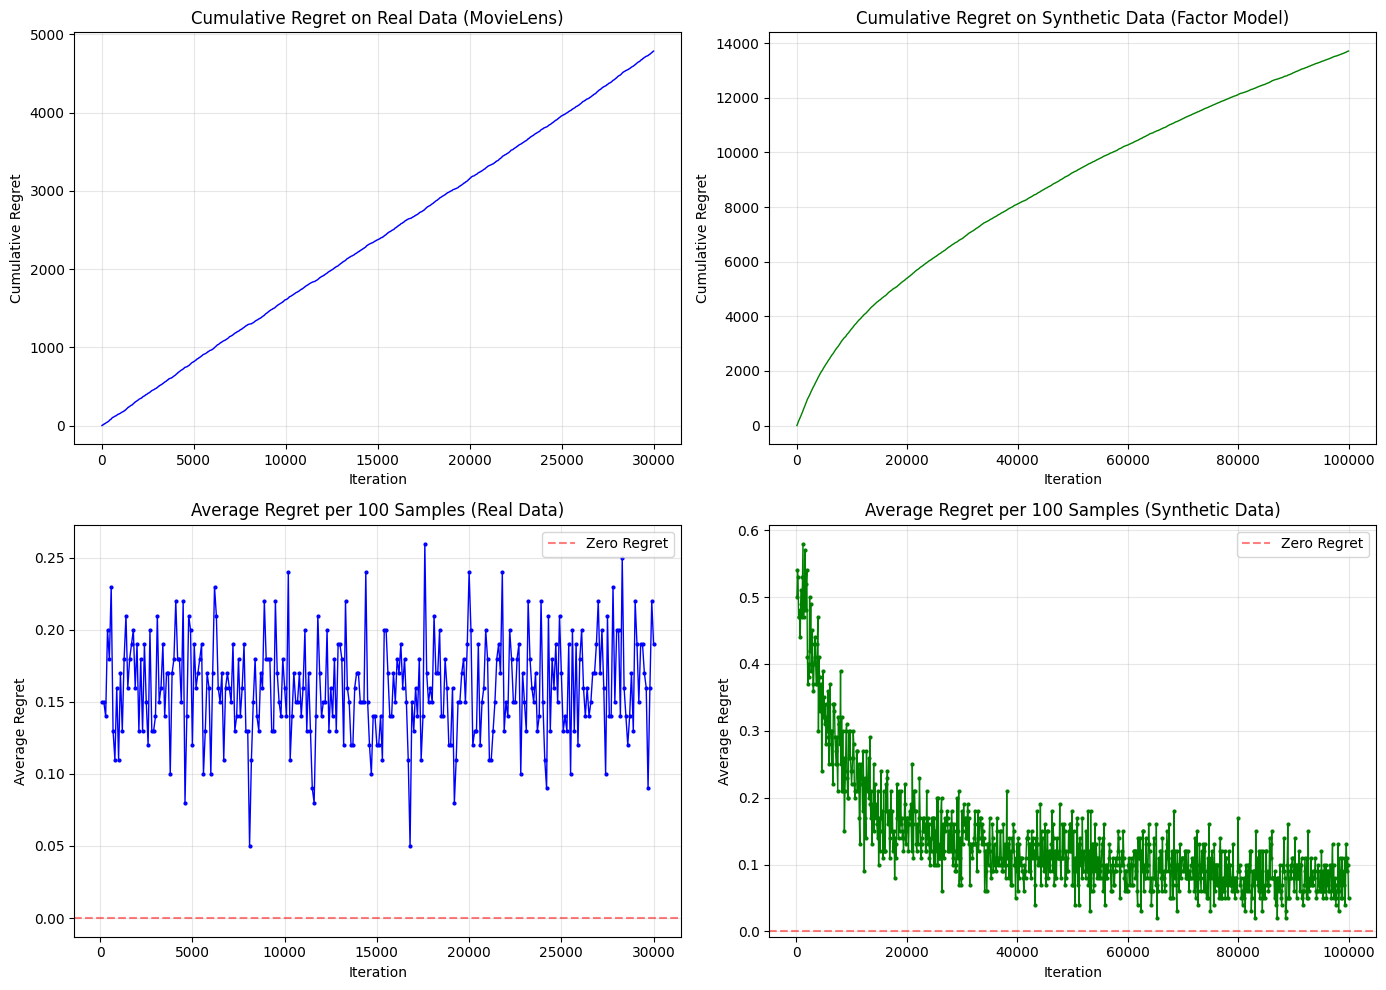


REGRET ANALYSIS SUMMARY

--- Real Data (MovieLens) ---
Total interactions: 30000
Total cumulative regret: 4787.00
Average regret per interaction: 0.1596
Final 100-sample avg regret: 0.1900

--- Synthetic Data (Factor Model) ---
Total interactions: 100000
Total cumulative regret: 13713.00
Average regret per interaction: 0.1371
Final 100-sample avg regret: 0.0500


In [ ]:
# ============================================================
# Part 1: Run KNN Bandit on Synthetic Data
# ============================================================

# Initialize and run KNN Bandit on synthetic data
print("Running KNN Bandit on synthetic data...")
knn_bandit_synthetic = KNNBandit(k=10, ratings=synthetic_ratings)
recommendations_synthetic = knn_bandit_synthetic.simulate(n_interactions=10**5)
print(f"Synthetic simulation completed with {len(recommendations_synthetic)} valid interactions.")

# ============================================================
# Part 2: Calculate Regret Metrics
# ============================================================

def calculate_regret_metrics(recommendations, optimal_reward=1):
    """
    Calculate cumulative regret and average regret per window.
    
    Args:
        recommendations: List of [user_id, item_id, reward]
        optimal_reward: The optimal reward (1 for binary rewards)
    
    Returns:
        cumulative_regret: Array of cumulative regret over time
        avg_regret_per_window: Average regret calculated every 100 samples
    """
    rewards = np.array([rec[3] for rec in recommendations])
    n = len(rewards)
    
    # Instantaneous regret (optimal - actual)
    instant_regret = optimal_reward - rewards
    
    # Cumulative regret
    cumulative_regret = np.cumsum(instant_regret)
    
    # Average regret per 100 samples
    window_size = 100
    n_windows = n // window_size
    avg_regret_per_window = []
    window_positions = []
    
    for i in range(n_windows):
        start_idx = i * window_size
        end_idx = (i + 1) * window_size
        window_regret = np.mean(instant_regret[start_idx:end_idx])
        avg_regret_per_window.append(window_regret)
        window_positions.append(end_idx)
    
    return cumulative_regret, avg_regret_per_window, window_positions

# Calculate metrics for real data
cumulative_regret_real, avg_regret_real, windows_real = calculate_regret_metrics(recommendations)

# Calculate metrics for synthetic data
cumulative_regret_synthetic, avg_regret_synthetic, windows_synthetic = calculate_regret_metrics(recommendations_synthetic)

# ============================================================
# Part 3: Plotting
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Cumulative Regret - Real Data
ax1 = axes[0, 0]
ax1.plot(cumulative_regret_real, color='blue', linewidth=1)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Cumulative Regret')
ax1.set_title('Cumulative Regret on Real Data (MovieLens)')
ax1.grid(True, alpha=0.3)

# Plot 2: Cumulative Regret - Synthetic Data
ax2 = axes[0, 1]
ax2.plot(cumulative_regret_synthetic, color='green', linewidth=1)
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Cumulative Regret')
ax2.set_title('Cumulative Regret on Synthetic Data (Factor Model)')
ax2.grid(True, alpha=0.3)

# Plot 3: Average Regret per 100 Samples - Real Data
ax3 = axes[1, 0]
ax3.plot(windows_real, avg_regret_real, color='blue', linewidth=1, marker='o', markersize=2)
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Average Regret')
ax3.set_title('Average Regret per 100 Samples (Real Data)')
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Zero Regret')
ax3.legend()

# Plot 4: Average Regret per 100 Samples - Synthetic Data
ax4 = axes[1, 1]
ax4.plot(windows_synthetic, avg_regret_synthetic, color='green', linewidth=1, marker='o', markersize=2)
ax4.set_xlabel('Iteration')
ax4.set_ylabel('Average Regret')
ax4.set_title('Average Regret per 100 Samples (Synthetic Data)')
ax4.grid(True, alpha=0.3)
ax4.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Zero Regret')
ax4.legend()

plt.tight_layout()
plt.show()


STARTING EXPERIMENT: SYNTHETIC DATA
Target Interactions: 50000
K values to test: [10, 50, 100]

  > Running simulations for K=10...
Starting simulation for 50000 valid interactions...
Simulation finished. Collected 50000 valid interactions.
Starting simulation for 50000 valid interactions...
Simulation finished. Collected 50000 valid interactions.
Starting simulation for 50000 valid interactions...
Simulation finished. Collected 50000 valid interactions.
Starting simulation for 50000 valid interactions...
Simulation finished. Collected 50000 valid interactions.

  > Running simulations for K=50...
Starting simulation for 50000 valid interactions...
Simulation finished. Collected 50000 valid interactions.
Starting simulation for 50000 valid interactions...
Simulation finished. Collected 50000 valid interactions.
Starting simulation for 50000 valid interactions...
Simulation finished. Collected 50000 valid interactions.
Starting simulation for 50000 valid interactions...
Simulation fini

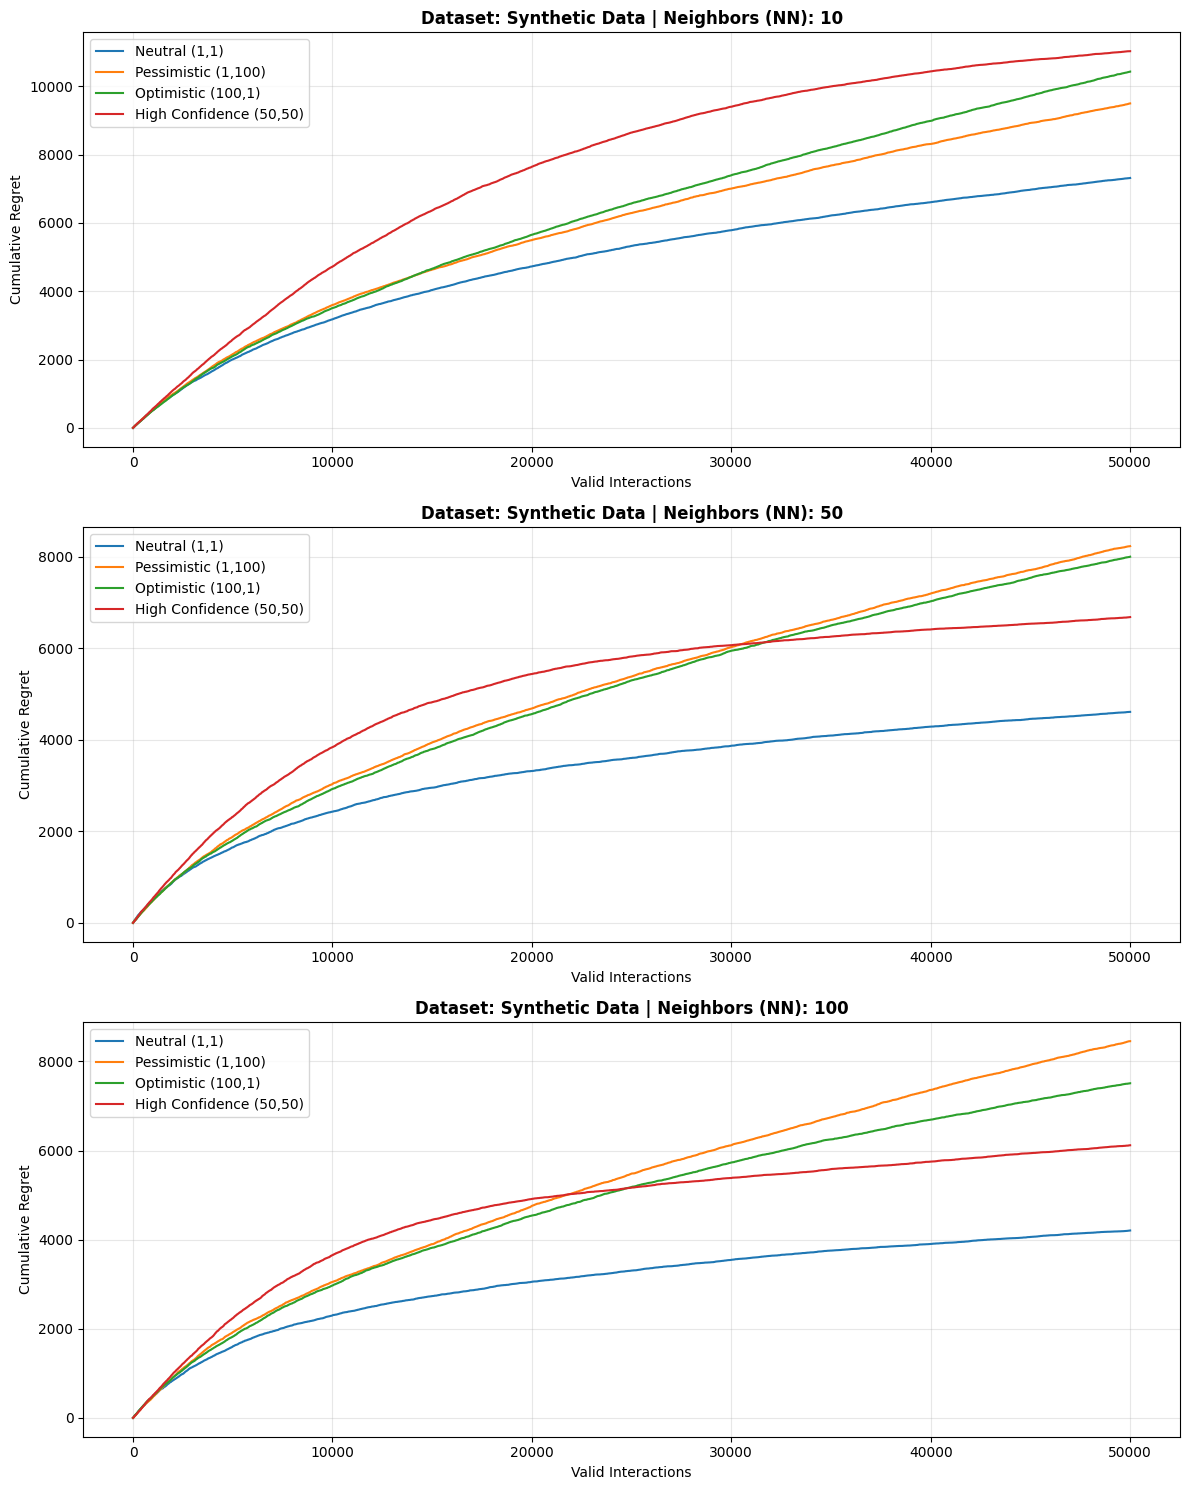


STARTING EXPERIMENT: MOVIELENS (REAL)
Target Interactions: 50000
K values to test: [10, 50, 100]

  > Running simulations for K=10...
Starting simulation for 50000 valid interactions...
Simulation finished. Collected 50000 valid interactions.
Starting simulation for 50000 valid interactions...
Simulation finished. Collected 50000 valid interactions.
Starting simulation for 50000 valid interactions...
Simulation finished. Collected 50000 valid interactions.
Starting simulation for 50000 valid interactions...
Simulation finished. Collected 50000 valid interactions.

  > Running simulations for K=50...
Starting simulation for 50000 valid interactions...
Simulation finished. Collected 50000 valid interactions.
Starting simulation for 50000 valid interactions...
Simulation finished. Collected 50000 valid interactions.
Starting simulation for 50000 valid interactions...
Simulation finished. Collected 50000 valid interactions.
Starting simulation for 50000 valid interactions...
Simulation fi

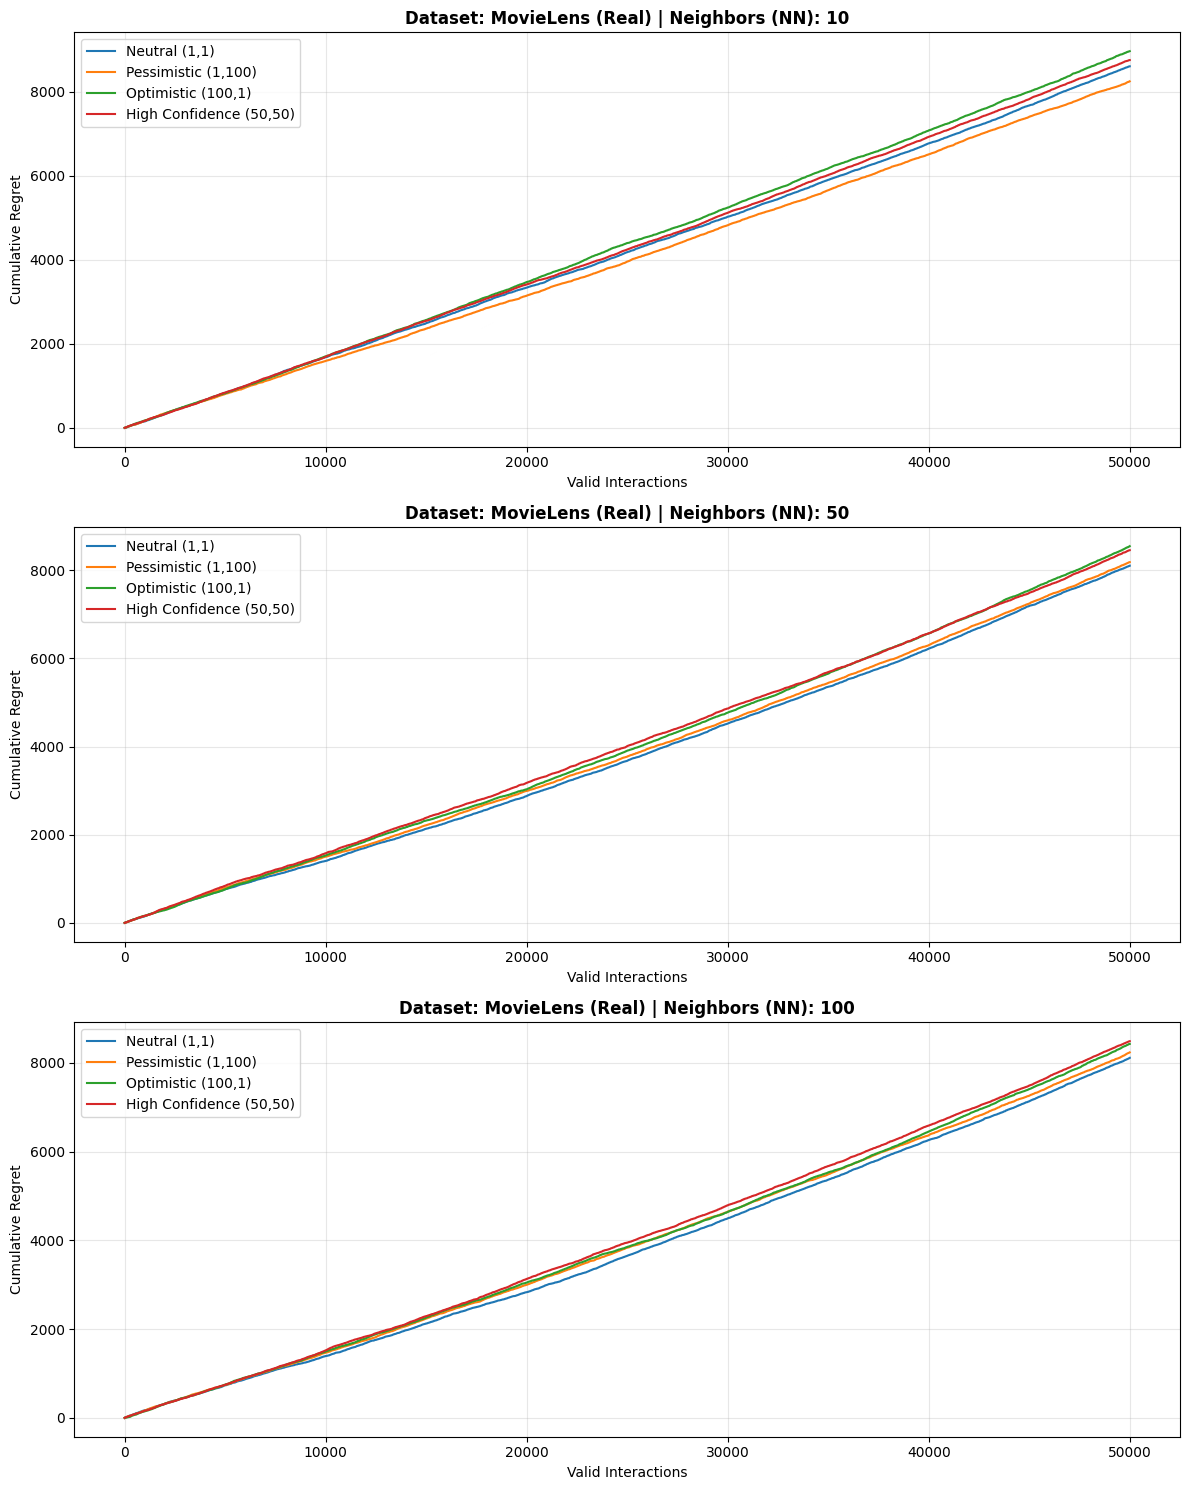


All experiments completed.


In [ ]:
# ============================================================
# 0. Helper Function: Regret Calculation
# ============================================================
def calculate_regret_metrics(recommendations, optimal_reward=1.0):
    # recommendations format: [user, item, rating, binary_reward]
    rewards = np.array([rec[3] for rec in recommendations]) 
    instant_regret = optimal_reward - rewards
    return np.cumsum(instant_regret)

# ============================================================
# 1. Experiment Configuration
# ============================================================

# A. Priors to Compare (Alpha, Beta, Label)
priors_to_test = [
    (1.0, 1.0, "Neutral (1,1)"),
    (1.0, 100.0, "Pessimistic (1,100)"),
    (100.0, 1.0, "Optimistic (100,1)"),
    (50.0, 50.0, "High Confidence (50,50)")
]

# B. Datasets Configuration
# format: "Name": { 'data': dataframe, 'n_sim': int, 'k_vals': list_of_int }
experiments_config = {
    "Synthetic Data": {
        "data": synthetic_ratings,       # Ensure this variable exists in your scope
        "n_sim": 50000,                  # Higher count for synthetic
        "k_vals": [10, 50, 100]          # K values to test
    },
    "MovieLens (Real)": {
        "data": ratings,                 # Ensure this variable exists in your scope
        "n_sim": 50000,                  # Lower count for real data (slower)
        "k_vals": [10, 50, 100]          # K values to test
    }
}

# ============================================================
# 2. Main Loop Over Datasets
# ============================================================

for dataset_name, config in experiments_config.items():
    
    data_source = config["data"]
    n_interactions = config["n_sim"]
    k_values = config["k_vals"]
    
    print(f"\n{'='*60}")
    print(f"STARTING EXPERIMENT: {dataset_name.upper()}")
    print(f"Target Interactions: {n_interactions}")
    print(f"K values to test: {k_values}")
    print(f"{'='*60}")
    
    # Create one big figure for this Dataset
    n_plots = len(k_values)
    fig, axes = plt.subplots(n_plots, 1, figsize=(12, 5 * n_plots), sharex=False)
    
    # Handle case where there is only 1 K value (axes is not a list)
    if n_plots == 1:
        axes = [axes]
        
    # Loop over K values
    for ax, k in zip(axes, k_values):
        print(f"\n  > Running simulations for K={k}...")
        
        # Loop over Priors
        for alpha, beta, label in priors_to_test:
            
            # Initialize Bandit
            bandit = KNNBandit(
                k=k, 
                ratings=data_source, 
                alpha_prior=alpha, 
                beta_prior=beta
            )
            
            # Run Simulation
            # We add a small safety multiplier to max_attempts to ensure we get our data
            recs = bandit.simulate(n_interactions=n_interactions, max_attempts=n_interactions*500)
            
            # Calculate Regret
            cum_regret = calculate_regret_metrics(recs, optimal_reward=1.0)
            
            # Plot Curve
            ax.plot(cum_regret, linewidth=1.5, label=label)
            
        # Subplot Formatting
        title_text = f"Dataset: {dataset_name} | Neighbors (NN): {k}"
        ax.set_title(title_text, fontsize=12, fontweight='bold')
        ax.set_ylabel("Cumulative Regret")
        ax.set_xlabel("Valid Interactions")
        ax.grid(True, alpha=0.3)
        ax.legend(loc="upper left")

    plt.tight_layout()
    plt.show()

print("\nAll experiments completed.")

In [ ]:
# ============================================================
# 0. Helper Function: Regret Calculation
# ============================================================
def calculate_regret_metrics(recommendations, optimal_reward=1.0):
    """
    Calculates the cumulative regret based on binary rewards.
    """
    # recommendations format: [user, item, rating, binary_reward]
    rewards = np.array([rec[3] for rec in recommendations]) 
    instant_regret = optimal_reward - rewards
    return np.cumsum(instant_regret)

# ============================================================
# 1. Experiment Configuration
# ============================================================

# Configuration parameters
dataset_name = "MovieLens (Real)"
data_source = ratings  # Assumes 'ratings' variable exists in your scope
n_interactions = 1_000_000  # 10^6 recommendations
k_value = 100  # Fixed K neighbors for this single run
max_attempts_limit = n_interactions * 1000  # Safety buffer for finding valid items

# Prior configuration (Neutral)
alpha_prior = 1.0
beta_prior = 1.0
label = f"Neutral Prior ({alpha_prior},{beta_prior})"

print(f"{'='*60}")
print(f"STARTING LARGE SCALE EXPERIMENT: {dataset_name.upper()}")
print(f"Target Interactions: {n_interactions}")
print(f"Prior: {label}")
print(f"Neighbors (K): {k_value}")
print(f"{'='*60}")

# ============================================================
# 2. Simulation & Plotting
# ============================================================

# Initialize Bandit with the specific prior and K
bandit = KNNBandit(
    k=k_value, 
    ratings=data_source, 
    alpha_prior=alpha_prior, 
    beta_prior=beta_prior
)

# Run Simulation
print(f"\n> Running simulation... (This may take time for {n_interactions} interactions)")
recs = bandit.simulate(n_interactions=n_interactions, max_attempts=max_attempts_limit)

# Calculate Regret
cum_regret = calculate_regret_metrics(recs, optimal_reward=1.0)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(cum_regret, linewidth=2, color='blue', label=label)

# Formatting
plt.title(f"Cumulative Regret over {n_interactions} Interactions\n{dataset_name} | K={k_value}", fontsize=14, fontweight='bold')
plt.ylabel("Cumulative Regret", fontsize=12)
plt.xlabel("Number of Recommendations", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc="upper left", fontsize=12)

plt.tight_layout()
plt.show()

print("\nExperiment completed.")